In [1]:
import numpy as np, os, matplotlib.pyplot as plt, torch
import torchvision.transforms as transforms

In [2]:
import datasets

In [25]:
db_list = [
    datasets.MS1MV2(),
    torch.utils.data.ConcatDataset([datasets.AffectNet(), datasets.RAFDB()]),
    datasets.FairFace(),
    datasets.MORPH(),
    datasets.UTKFace(),
]

In [26]:
balanced_db = datasets.create_balanced_dataset(db_list)

Largest dataset size: 5822653
Dataset MS1MV2: Original=5822653, Repeating 1 times.
Dataset ConcatDataset: Original=49556, Repeating 117 times.
Dataset FairFace: Original=97698, Repeating 59 times.
Dataset MORPH: Original=50015, Repeating 116 times.
Dataset UTKFace: Original=23686, Repeating 245 times.


In [27]:
db_loader = torch.utils.data.DataLoader(
    balanced_db,
    batch_size = 8,
    shuffle = True
)
images, labels = next(iter(db_loader))

In [28]:
labels

{'face_recognition': tensor([   -1,    -1,    -1,    -1,    -1, 49244,    -1, 28018]),
 'emotion': tensor([-1, -1, -1, -1, -1, -1, -1, -1]),
 'age': tensor([22, 24, 10, 40, 17, -1, 77, -1]),
 'gender': tensor([ 1,  1,  0,  0,  1, -1,  1, -1]),
 'race': tensor([-1, -1,  0,  0, -1, -1,  0, -1])}

In [29]:
labels['face_recognition'][labels['face_recognition'] != -1]

tensor([49244, 28018])

In [30]:
race_translation = {
    0 : 'White',
    1 : 'Black',
    2 : 'Asian',
    3 : 'Indian',
    4 : 'Other'
}

In [31]:
gender_translation = {
    1 : 'Male',
    0 : 'Female'
}

In [32]:
emotion_translation = {
    0 : 'anger',
    1 : 'disgust',
    2 : 'fear',
    3 : 'happy',
    4 : 'sad',
    5 : 'surprise',
    6 : 'neutral'
}

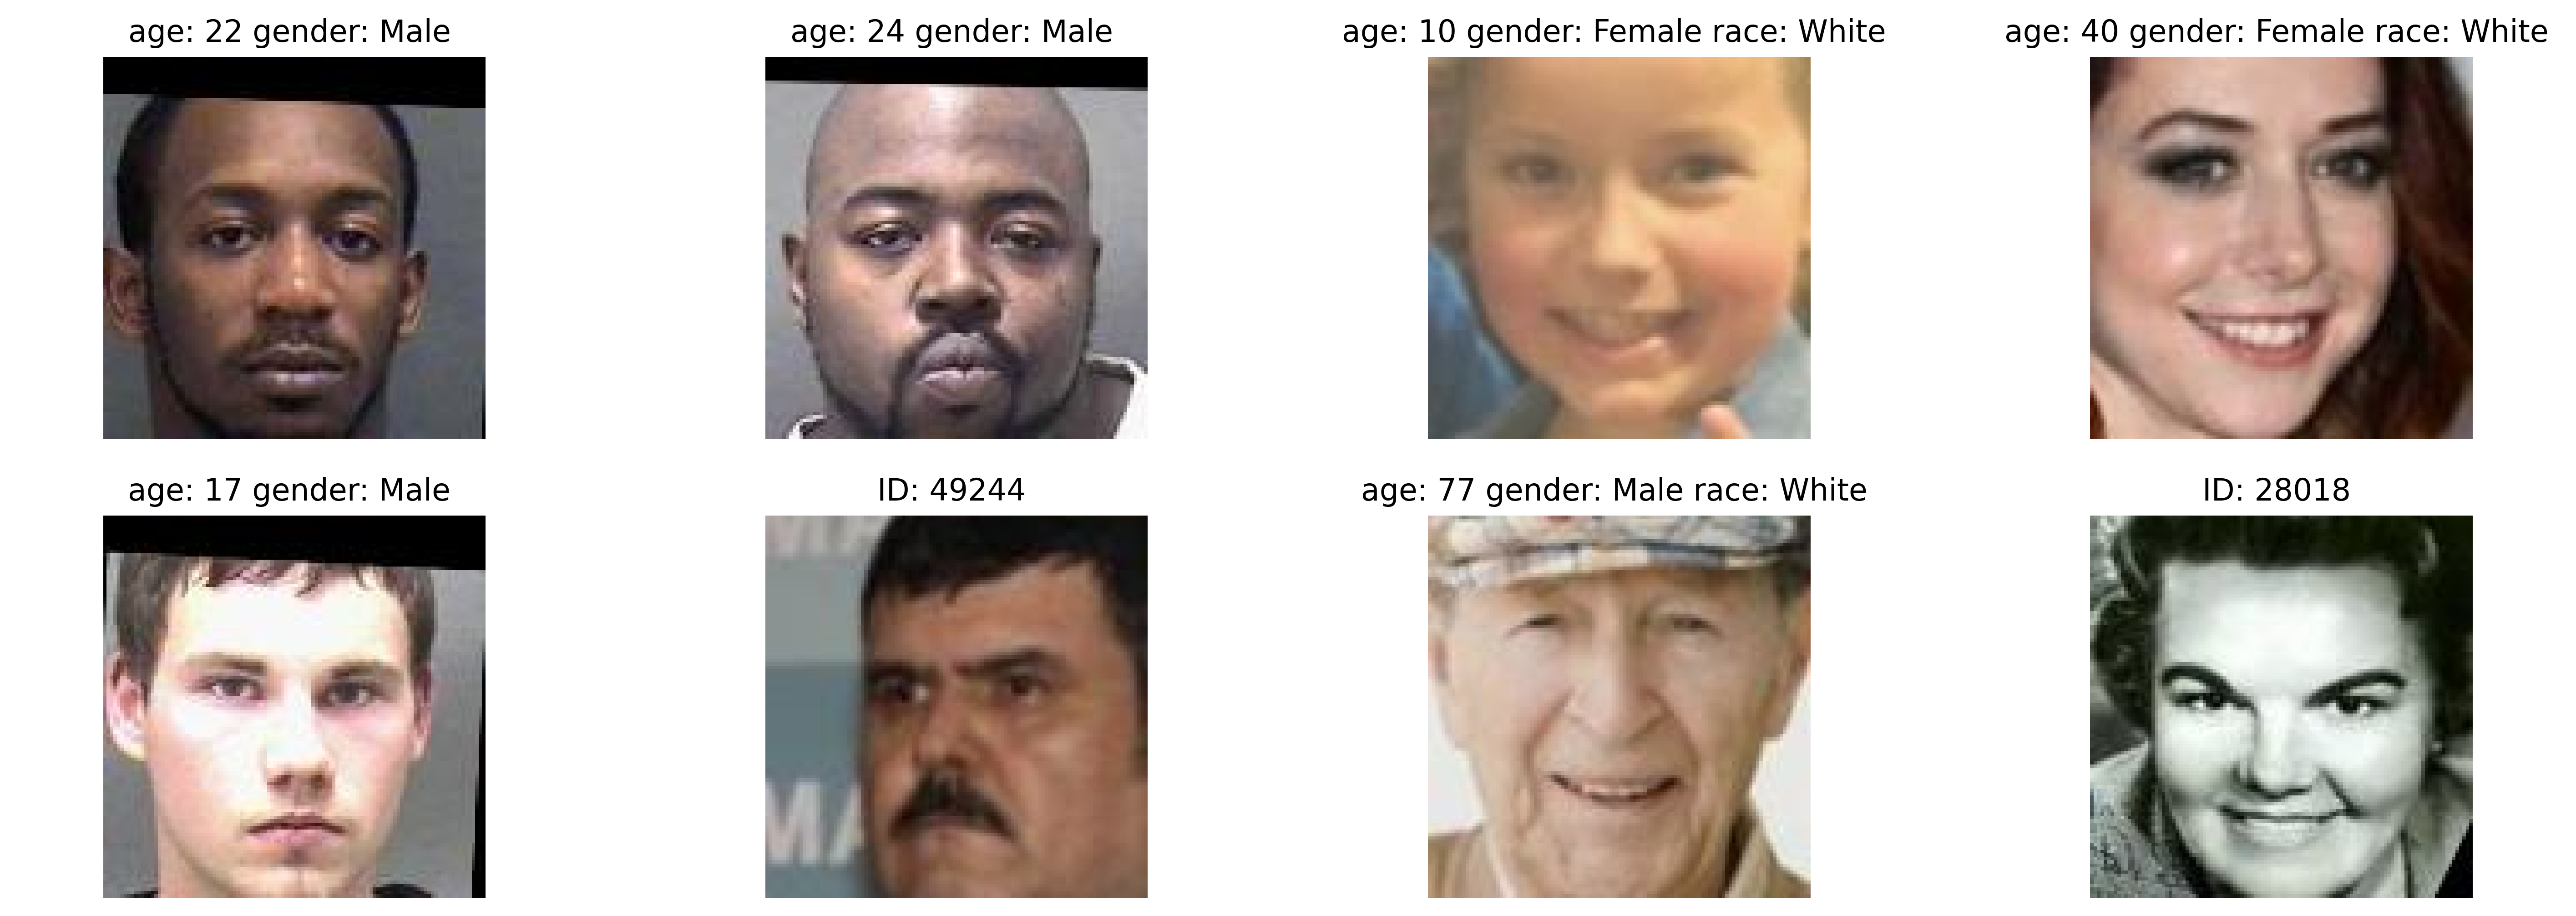

In [33]:
plt.figure(figsize = (18, 6), dpi = 400)
plt.axis('off')

for i in range(8):
    image = images[i]
    label_text = ''

    face_label = labels['face_recognition'][i]
    if face_label != -1:
        label_text += f'ID: {face_label} '

    emotion_label = labels['emotion'][i]
    if emotion_label != -1:
        label_text += f'emotion: {emotion_translation[int(emotion_label)]} '

    age_label = labels['age'][i]
    if age_label != -1:
        label_text += f'age: {age_label} '

    gender_label = labels['gender'][i]
    if gender_label != -1:
        label_text += f'gender: {gender_translation[int(gender_label)]} '

    race_label = labels['race'][i]
    if race_label != -1:
        label_text += f'race: {race_translation[int(race_label)]} '

    plt.subplot(2, 4, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(label_text)
    plt.axis('off')
plt.show()